This notebook is for analyzing depth-averaged momentum budget using MOM6 output. The effects of time-averaging and spatial filtering are discussed.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)

print(client)

<Client: 'tcp://127.0.0.1:34329' processes=4 threads=16, memory=270.45 GB>


In [2]:
# Functions for plotting

def plot_map(ax, da, vmin=-999, vmax=999, vstep=1,
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, format='%.1e', extend='both', shrink=0.6)
    cb.ax.tick_params(labelsize=12)

    p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [16]:
def apply_gaussian_filter(field,wetMask):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

In [7]:
ds = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/OM125_monthly.nc")

print(ds)

<xarray.Dataset>
Dimensions:           (nv: 2, xh: 2880, xq: 2880, yh: 2240, yq: 2240)
Coordinates:
  * nv                (nv) float64 1.0 2.0
    time              object ...
  * xq                (xq) float64 -298.5 -298.4 -298.3 ... 61.12 61.23 61.35
  * yh                (yh) float64 -83.62 -83.58 -83.54 ... 89.86 89.92 89.97
  * xh                (xh) float64 -298.6 -298.5 -298.4 ... 61.05 61.16 61.28
  * yq                (yq) float64 -83.6 -83.56 -83.52 ... 89.89 89.95 90.0
    geolat            (yh, xh) float32 ...
    geolat_c          (yq, xq) float32 ...
    geolat_u          (yh, xq) float32 ...
    geolat_v          (yq, xh) float32 ...
    geolon            (yh, xh) float32 ...
    geolon_c          (yq, xq) float32 ...
    geolon_u          (yh, xq) float32 ...
    geolon_v          (yq, xh) float32 ...
Data variables:
    average_DT        timedelta64[ns] ...
    average_T1        object ...
    average_T2        object ...
    hf_CAu_2d         (yh, xq) float32 ...
   

In [8]:
grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

topo_x = - grid.diff(ds.deptho * ds.dyt, 'X', boundary='fill') / ds.areacello_cu # negative sign in gradient calculation as we are using ocean depth
tau_f = topo_x * grid.interp(ds.pbo, 'X',  boundary='fill') # first interpolate pbo on u points

In [12]:
print(tau_f)

<xarray.DataArray (yh: 2240, xq: 2880)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * yh        (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.86 89.92 89.97
  * xq        (xq) float64 -298.5 -298.4 -298.3 -298.2 ... 61.12 61.23 61.35
    time      object ...
    geolat_u  (yh, xq) float32 ...
    geolon_u  (yh, xq) float32 ...


# Laplacian steps: 13; # Biharmonic steps: 1


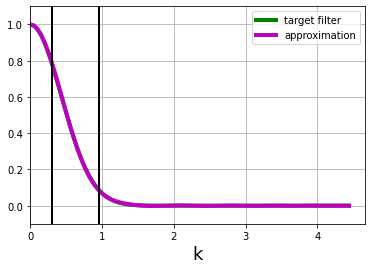

In [20]:
# Guassian Filter set 

filter_fac = 8 # 1/8 --> 1 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g=15
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [17]:
dims = ['yh', 'xq']

dataBar = tau_f.copy() # Initialize the filtering process
dataBar = dataBar * ds['areacello_cu']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_u'], input_core_dims=[dims,dims],
                         output_core_dims=[dims], output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello_cu'] # divide by cell area    
            
tau_f_1Deg = dataBar.copy()

In [18]:
print(tau_f_1Deg)

<xarray.DataArray (yh: 2240, xq: 2880)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time      object 0005-03-16 12:00:00
  * xq        (xq) float64 -298.5 -298.4 -298.3 -298.2 ... 61.12 61.23 61.35
  * yh        (yh) float64 -83.62 -83.58 -83.54 -83.5 ... 89.86 89.92 89.97
    geolat_u  (yh, xq) float32 -82.45596 -82.45444 ... 64.08629 64.03161
    geolon_u  (yh, xq) float32 -298.53333 -298.41705 ... 59.99974 60.0


# Laplacian steps: 58; # Biharmonic steps: 1


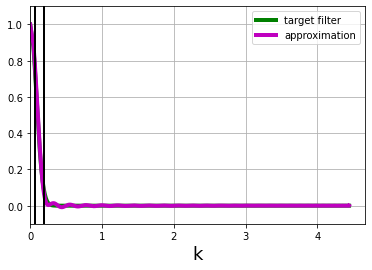

In [24]:
# Guassian Filter set 

filter_fac = 40 # 1/8 --> 5 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g=60
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

In [25]:
dims = ['yh', 'xq']

dataBar = tau_f.copy() # Initialize the filtering process
dataBar = dataBar * ds['areacello_cu']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_u'], input_core_dims=[dims,dims],
                         output_core_dims=[dims], output_dtypes=[dataBar.dtype], dask='parallelized')

#dataBar.data = dataBar.data.map_blocks(cp.asnumpy) # send back to host
dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds['areacello_cu'] # divide by cell area    
            
tau_f_5Deg = dataBar.copy()

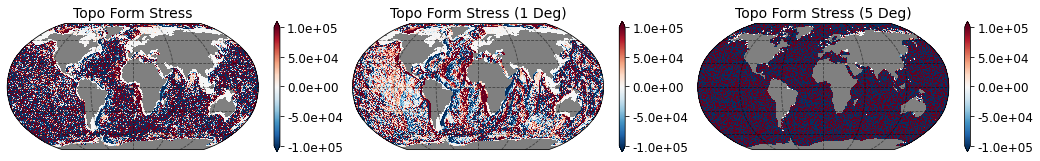

In [26]:
max_r = 1.e5

grid = plt.GridSpec(1, 3, wspace=0.1, hspace=0.1)
fig = plt.figure(figsize=[18,4])

ax = fig.add_subplot(grid[0, 0], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f, vmin=-max_r, vmax=max_r, vstep=2.e2*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topo Form Stress')

ax = fig.add_subplot(grid[0, 1], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f_1Deg, vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topo Form Stress (1 Deg)')

ax = fig.add_subplot(grid[0, 2], projection=ccrs.Robinson(),facecolor='grey')
_ = plot_map(ax, tau_f_5Deg, vmin=-max_r, vmax=max_r, vstep=2.e-1*max_r,
                   lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='Topo Form Stress (5 Deg)')

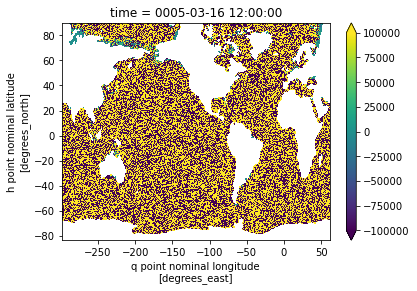

In [28]:
tau_f_5Deg.plot(vmin=-max_r, vmax=max_r)

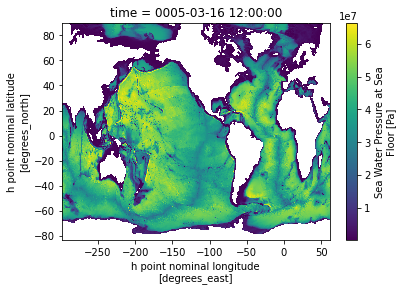

In [9]:
ds.pbo.plot()

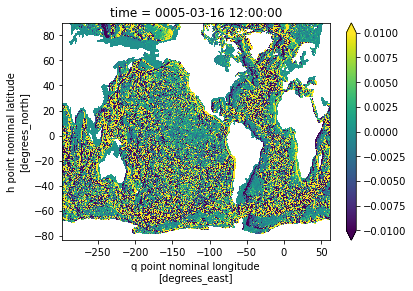

In [11]:
topo_x.plot(vmin = -.01, vmax=0.01)

In [29]:
ds.close()
client.close()
cluster.close()